# Basic python imports and model settings

In [18]:
import underworld.visualisation as vis

from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os

import time as ti

# uw.matplotlib_inline()

# details of the bottom curve
L = [160, 80, 40, 20, 10, 5] # values in Experiment D AND in Experiment B
i = 2
maxX = L[i] * 1000.
omega = 2.0 * np.pi / maxX
average_bedthickness = 1000.
surface_height = average_bedthickness
maxY = surface_height + 0.     # free air = maxY - surface_height (defined above)

beta_square = fn.misc.constant(1.)
beta_square = 1001. + 1000. * fn.math.sin(omega * fn.input()[0])

A = 1e-16	# I think, this is already per year.
n = 3.

resY = 10
resX = int(resY * maxX / maxY)

print("resX: " + str(resX) + " resY: " + str(resY))

# generate output path
outputPath = os.path.join(os.path.abspath("."), "output/")
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

# generate output file
outputFile = os.path.join(os.path.abspath("."), "output.txt")
if os.path.exists(outputFile):
    os.rename(outputFile, outputFile + ".bkp")

delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?
update_figures_after_n_timesteps = 1
number_of_deformation_lines = 11

number_of_deformation_points = 20000
distance_between_deformation_lines = maxY / (number_of_deformation_lines + 1)

resX: 400 resY: 10


# Mesh + mesh variables

In [3]:
elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY),
                                minCoord=(0., 0.),
                                maxCoord=(maxX, maxY),
                                periodic=[True, False])

submesh = mesh.subMesh

# save the mesh
# mesh.save(outputPath + "mesh.h5")

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
pressureField = uw.mesh.MeshVariable(mesh=mesh.subMesh, nodeDofCount=1)

viscosityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

rockIceInterface = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)
rockIceInterface.data[:] = False

strainRateField = mesh.add_variable(nodeDofCount=1)
tractionField = mesh.add_variable(nodeDofCount=2)

tractionField.data[:] = 0.
pressureField.data[:] = 0.
velocityField.data[:] = [0., 0.]

# Swarm

In [4]:
part_per_cell = 50
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(
    swarm=swarm, particlesPerCell=part_per_cell)
swarm.populate_using_layout(layout=swarmLayout)

surfaceSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
deformationSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
pop_control1 = uw.swarm.PopulationControl(
    swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(surfaceSwarm)
pop_control3 = uw.swarm.PopulationControl(deformationSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).

advector1 = uw.systems.SwarmAdvector(
    swarm=swarm,            velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(
    swarm=surfaceSwarm,     velocityField=velocityField, order=2)
advector3 = uw.systems.SwarmAdvector(
    swarm=deformationSwarm, velocityField=velocityField, order=2)

# Tracking different materials

materialVariable = swarm.add_variable(dataType="int", count=1)

# passive markers at the surface are inserted whenever 100 m of new snow hav been created in the main loop
deformationPoints = np.array(np.meshgrid(np.linspace(0., maxX, int(
    number_of_deformation_points)), np.linspace(0., maxY, number_of_deformation_lines))).T.reshape(-1, 2)
deformationSwarm.add_particles_with_coordinates(deformationPoints)

surfacePoints = np.zeros((int(number_of_deformation_points), 2))
surfacePoints[:, 0] = np.linspace(
    0., maxX, int(number_of_deformation_points))
surfacePoints[:, 1] = surface_height
surfaceSwarm.add_particles_with_coordinates(surfacePoints)

particleDensity = swarm.add_variable(dataType="double", count=1)
particleDensity.data[:] = 0.0

# Initialise the 'materialVariable' data to represent different materials.
materialA = 0  	# accommodation layer, a.k.a. Sticky Air
materialV = 1  	# ice, isotropic
materialR = 2   # rock

coord = fn.input()

conditions = [(coord[1] > surface_height, materialA),
              (True, materialV)]

materialVariable.data[:] = fn.branching.conditional(conditions).evaluate(swarm)

iceAirInterfaceSet = []
for index, coord in enumerate(mesh.data):
    if coord[1] <= surface_height:
        iceAirInterfaceSet.append(index)
iceAirInterfaceSet = np.argsort(mesh.data[iceAirInterfaceSet, 1])[-resX:-1]
iceAirInterfaceSet = np.argsort(iceAirInterfaceSet, 0)

# Functions

In [5]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

minViscosityIceFn = fn.misc.constant(1e+5 / 3.1536e7)
maxViscosityIceFn = fn.misc.constant(1e+15 / 3.1536e7)

viscosityFnAir = fn.misc.constant(1e6 / 3.1536e7)
viscosityFnRock = fn.misc.constant(1e17 / 3.1536e7)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn)**((1.-n) / n)
viscosityFnIce = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)

viscosityMap = {materialV: viscosityFnIce,
                materialA: viscosityFnAir,
                materialR: viscosityFnRock}

viscosityFn = fn.branching.map(fn_key=materialVariable, mapping=viscosityMap)

logViscosityFn = fn.math.log10(fn.misc.max(fn.misc.min(viscosityFnIceBase, viscosityFnRock), viscosityFnAir))

devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

densityFnAir = fn.misc.constant(0.)
densityFnIce = fn.misc.constant(910.)
densityFnRock = fn.misc.constant(2700.)

densityMap = {materialA: densityFnAir,
              materialV: densityFnIce,
              materialR: densityFnRock}

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)

particleDensity.data[:] = densityFn.evaluate(swarm)

surf_inclination = 0.1 * np.pi / 180. # 0.1 = Experiment D, 0.5 = Experiment B
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination))
buoyancyFn = densityFn * z_hat * 9.81

# Solver and boundary conditions

In [33]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base = mesh.specialSets["MinJ_VertexSet"]
top = mesh.specialSets["MaxJ_VertexSet"]

velocityField.data[:] = [0., 0.]

botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']
leftSet = mesh.specialSets['Left_VertexSet']
rightSet = mesh.specialSets['Right_VertexSet']

# cond_dirichlet = uw.conditions.DirichletCondition(variable=velocityField, indexSetsPerDof=(leftSet + rightSet, topSet))

cond_dirichlet = uw.conditions.DirichletCondition(variable=velocityField, indexSetsPerDof=(None, topSet + botSet))

# Traction is force per unit area associated with a specific surface 
# ie, traction = stress * surface_unit_normal
tractionField.data[base, 0] = (910. * 9.81 * 1000. * np.sin(surf_inclination) / 
                               (1000.1 + 1000. * np.sin(omega * mesh.data[base,0])))
#tractionField.data[base, 1] = 0.

basal_vel = ((devStressFn[2] / beta_square), fn.misc.constant(0.))
# basal_vel = (fn.misc.constant(0.), fn.misc.constant(0.))
basal_vel = (910. * 9.81 * 1000. * np.sin(surf_inclination) / beta_square, fn.misc.constant(0.))

velocityField.data[:] = [0., 0.]
tractionBC = uw.conditions.NeumannCondition( variable=velocityField, fn_flux=tractionField, indexSetsPerDof=(botSet, None))
#tractionBC = uw.conditions.NeumannCondition( variable=velocityField, fn_flux=basal_vel, indexSetsPerDof=(botSet, None))

stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=[
            tractionBC, 
            cond_dirichlet,
            ],
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

# solver.set_inner_method("lu")
solver.set_inner_method("superlu")
# solver.set_inner_method("mumps")

solver.set_penalty(1.0e10)  # higher penalty = larger stability
# solver.options.scr.ksp_rtol = 1.0e-3

# nl_tol = 2.e1
nl_tol = 2.e-1

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)

Calibration pressure -4017661.221552178
Calibration pressure -4017906.269538934

 
Pressure iterations:   2
Velocity iterations:   1 (presolve)      
Velocity iterations:   2 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   4 (total solve)   
 
SCR RHS  setup time: 1.0967e-01
SCR RHS  solve time: 2.6751e-03
Pressure setup time: 1.8260e-03
Pressure solve time: 1.0579e-02
Velocity setup time: 4.7684e-07 (backsolve)
Velocity solve time: 8.2572e-03 (backsolve)
Total solve time   : 1.5384e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



# Test the traction field

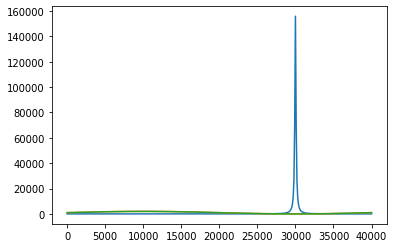

In [29]:
pyplot.plot(mesh.data[base, 0], tractionField.data[base, 0])
pyplot.plot(mesh.data[base, 0], beta_square.evaluate(mesh.data[base]))
pyplot.plot(mesh.data[base, 0], beta_square[0].evaluate(mesh.data[base]))

# Figures


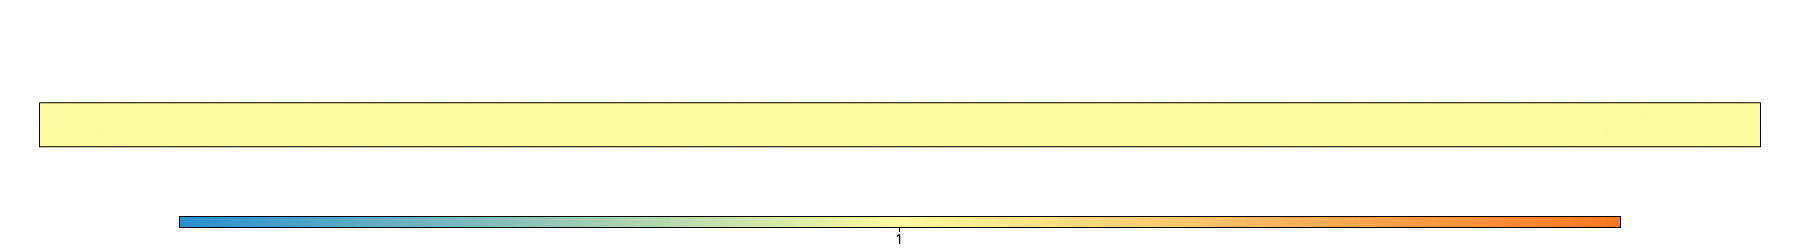


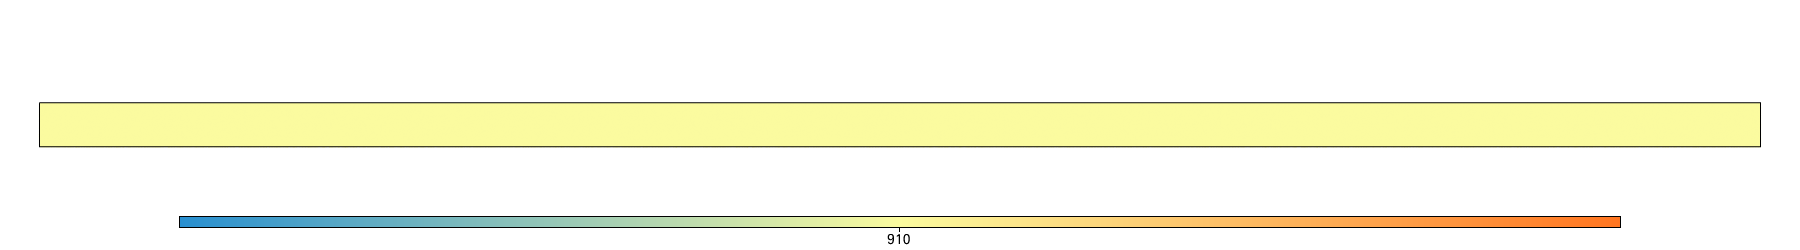


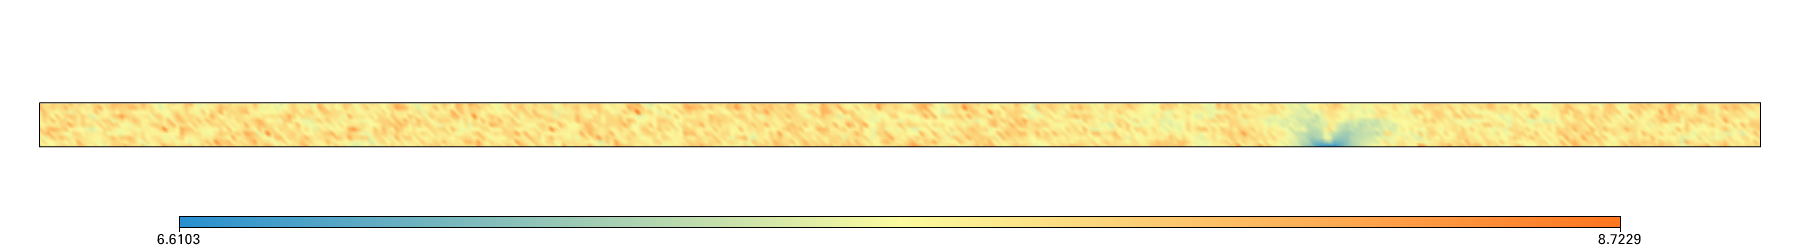


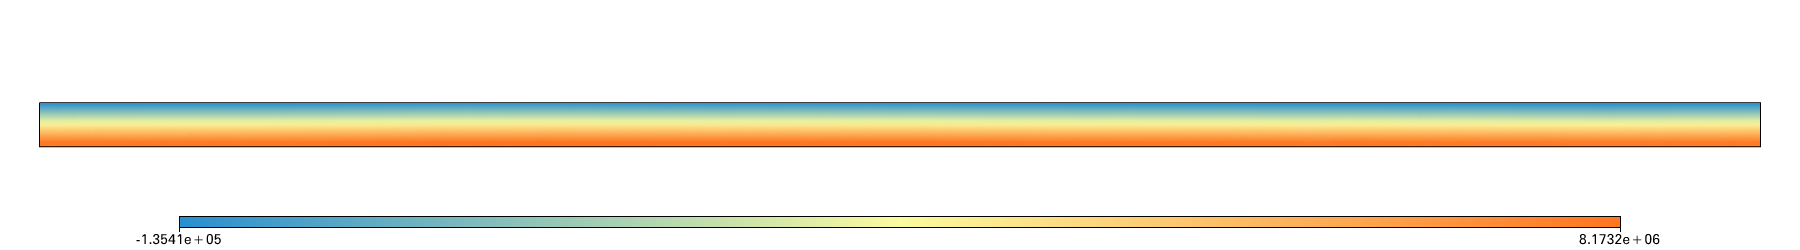


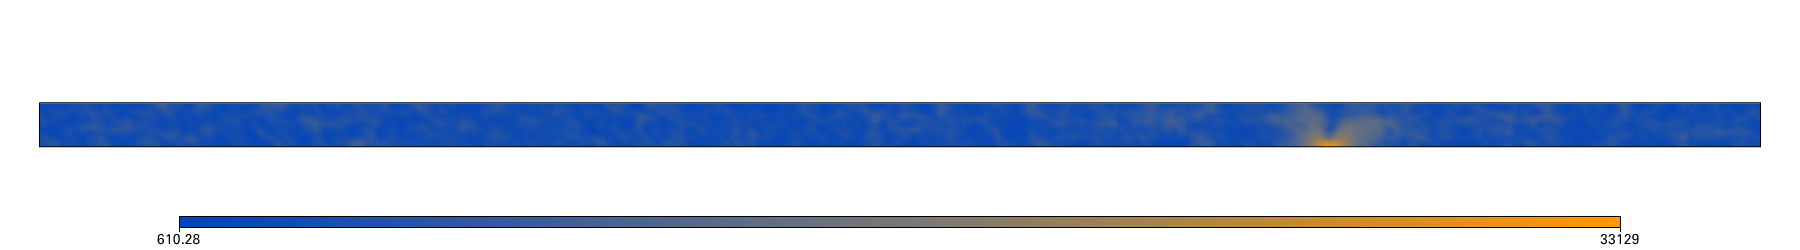


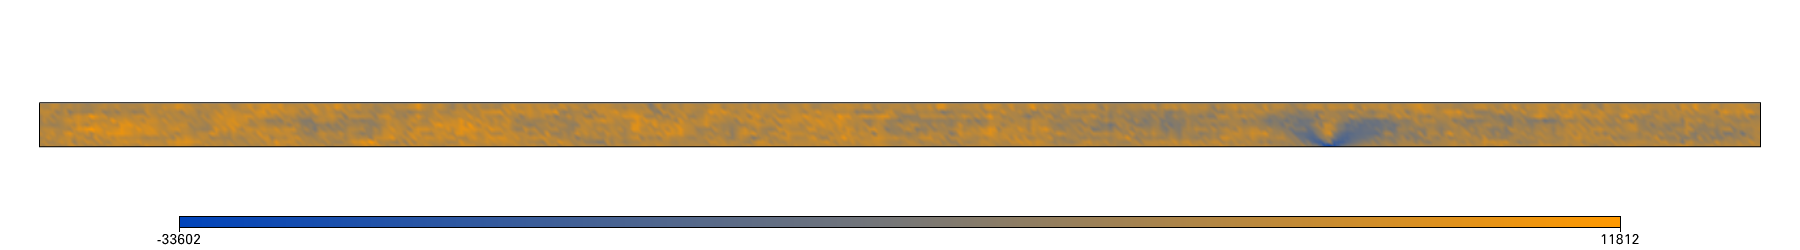

In [36]:
figMaterial = vis.Figure(figsize=(1800, 250))
figMaterial.append(vis.objects.Points( swarm, materialVariable, pointSize=3.0))
figMaterial.show()
#figMaterial.save_image("material.png")

figDensity = vis.Figure(figsize=(1800, 250))
figDensity.append(vis.objects.Points( swarm, particleDensity, pointSize=3.0))
figDensity.show()
#figDensity.save_image("density.png")

figViscosity = vis.Figure(figsize=(1800, 250))
figViscosity.append(vis.objects.Surface(mesh, logViscosityFn, ))
figViscosity.show()
#figViscosity.save_image("logviscosity.png")

figPressure = vis.Figure(figsize=(1800, 250))
figPressure.append(vis.objects.Surface(mesh, pressureField))
figPressure.show()
#figPressure.save_image("pressure.png")

meshDevStress = mesh.add_variable( 1 )
projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )
projectorStress.solve()
figMeshStress = vis.Figure(figsize=(1800, 250))
figMeshStress.append( vis.objects.Surface(mesh, meshDevStress, colours="#0044BB, #777777, #FF9900") )
figMeshStress.show()
#figMeshStress.save_image("meshStress.png")

figHorShearStress = vis.Figure(figsize=(1800, 250))
figHorShearStress.append(vis.objects.Surface(mesh, devStressFn[2], colours="#0044BB, #777777, #FF9900") )
figHorShearStress.show()
#figHorShearStress.save_image("horShearStress.png")

# Functions

In [8]:
# The stress is only guaranteed to be accurate when integrated across an element. Fluctuations
# within an element can be significant. Mapping to the mesh can help

def update_advection_diffusion(t):

    global meshV, maxX, maxY, snowfall_rate, nl_tol
    global calibrate_pressure

    tin = t

    while t > 0.:
    
        solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
        #solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
        
        # Retrieve the maximum possible timestep for the advection system.
        dt = min([advector1.get_max_dt(), advector2.get_max_dt(), advector3.get_max_dt(), advDiff.get_max_dt()])
        
        if dt > t:
            dt = t
            t = 0.
        else:
            t = t - dt
            
        advDiff.integrate(dt)
        # Advect using this timestep size.
        advector1.integrate(dt) # the swarm
        #advector2.integrate(dt)# the surface swarm
        advector3.integrate(dt) # the deformation swarm

        
        # particle population control
        # not sure, if this is really necessary. it is _not_ in the standard advecton code, but only if there is a mesh-deformation involved. my hope would be that this command will not allow underresolved cells
        pop_control1.repopulate()
        #pop_control2.repopulate()
        #pop_control3.repopulate()
        
        particleTemperature.data[:] = temperatureField.evaluate(swarm)
        particleDensity.data[:] = densityFn.evaluate(swarm)
        
        # c_axis_rotation(dt)

    return time+tin

def update_infinite_flow(t):
    
    """
    In order for infinite flow to work you need to
    a) use the same medication as MC Escher,
    b)	1) generate 'inclination' --> z_hat definition
        2) activate wrapping by setting 'periodic = [True, False]' during the mesh creation
    """
    
    global meshV, maxX, maxY, snowfall_rate, nl_tol
    global calibrate_pressure
    
    tin = t
    
    while t:
        
        solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
        
        # Retrieve the maximum possible timestep for the advection system.
        dt = min([advector1.get_max_dt(), advector2.get_max_dt(), advector3.get_max_dt()])
        
        print(f'---------------------{dt}')
        #exit(0)
        
        if dt > t:
            dt = t
            t = 0.
        else:
            t = t - dt
            
        print (t)
        
        # Advect using this timestep size.
        advector1.integrate(dt) # the swarm
        #advector2.integrate(dt)# the surface swarm
        advector3.integrate(dt) # the deformation swarm
        
        # particle population control
        # not sure, if this is really necessary. it is _not_ in the standard advecton code, but only if there is a mesh-deformation involved. my hope would be that this command will not allow underresolved cells
        pop_control1.repopulate()
        #pop_control2.repopulate()
        #pop_control3.repopulate()
        
        # c_axis_rotation(dt)

    return time+tin

# Main function

In [9]:
def main():
    
    # Stepping. Initialise time and timestep.
    
    global time, step
    time = 0.
    step = 0
    nsteps = 10001

    while step < nsteps:

        delta_timestep = 1.
        time = update_infinite_flow(t=delta_timestep)
        
        if (True): #step % update_figures_after_n_timesteps == 0):

            (area,) = surfaceArea.evaluate()
            (p0,) = surfacePressureIntegral.evaluate()
            print(surfaceArea.evaluate())
            print(surfacePressureIntegral.evaluate())
            print(p0 / area)
            #pressureField.data[:] -= p0 / area
            
            figPressure.save_image( outputPath + "pressure-" + str(step).zfill(4) + " - " + str(time) + ".png")
            figMaterial.save_image( outputPath + "material-" + str(step).zfill(4) + " - " + str(time) + ".png")
            figViscosity.save_image((outputPath + "logviscosity-" + str(step).zfill(4) + " - " + str(time) + ".png"))
            figDensity.save_image(outputPath + "density-" + str(step).zfill(4) + " - " + str(time) + ".png")
            figHorShearStress.save_image( outputPath + "horShearStress-" + str(step).zfill(4) + " - " + str(time) + ".png")

        step += 1
        exit (0)
            
if __name__ == "__main__":
    main()

Calibration pressure -4017326.416698367
Calibration pressure -4017778.793142489
---------------------1.602370019648159e-10
0.999999999839763
Calibration pressure -4017991.2685821895
Calibration pressure -4018523.130015809
---------------------1.4646685385954842e-10
0.9999999996932961
Calibration pressure -4017756.912199889
Calibration pressure -4018290.614276228
---------------------1.498064889638971e-10
0.9999999995434896
Calibration pressure -4017951.94341161
Calibration pressure -4018521.678269387
---------------------1.4579799136662543e-10
0.9999999993976916


KeyboardInterrupt: 